In [ ]:
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import json
import spacy_udpipe

import sklearn_crfsuite
from sklearn_crfsuite import metrics
import crfs

import pycrfsuite

In [ ]:
f=open("full_training_set_CRF_tagged.json")
full_training_set_CRF = json.load(f)

f=open("full_test_set_CRF_tagged.json")
full_test_set_CRF = json.load(f)

In [ ]:
from nltk.tokenize import sent_tokenize

def tag_sentences(document):
    "Receive a document and the number of the document. Then it returns the labels divided in sentences"    
    text = document['text']
    tagged_sentences = []
    tag_index = 0
    
    for sentence in sent_tokenize(text):
        if(any(char.isalpha() for char in sentence)):
            l = []
            for word in word_tokenize(sentence):
                 l.append(full_training_set_CRF[n]['text_tagged'][tag_index][1])
                 tag_index += 1
            tagged_sentences.append(l)

    return tagged_sentences

In [ ]:
def features_sentences(doc):
    "Receive a document return the features divided by sentences."
    text = doc['text']
    tag_index = 0
    l_text_features=[]
    for i in range(len(sent_tokenize(text))):
        sentence=[]
        if(any(char.isalpha() for char in sent_tokenize(text)[i])):
            for j in range(len(word_tokenize(sent_tokenize(text)[i]))):
                sentence.append(doc["words"][tag_index])
                tag_index+=1
            l_text_features.append(sentence)
    

    for a in range(len(l_text_features)):
        for i in range(len(l_text_features[a])):
            features=list(l_text_features[a][i].values())
            l_text_features[a][i]=list(features[0].values())

    return l_text_features

In [ ]:
x_train = []
y_train = []

for i in range(len(full_training_set_CRF)):
    y_train += tag_sentences(full_training_set_CRF[i])
    x_train += features_sentences(full_training_set_CRF[i])

In [ ]:
x_test = []
y_test = []

for i in range(len(full_test_set_CRF)):
    y_test += tag_sentences(full_test_set_CRF[i])
    x_test += features_sentences(full_test_set_CRF[i])

In [ ]:
def convert_to_strings(lst):
    new_list = []
    for sentence in lst:
        new_sentence = []
        for word in sentence:
            new_word = []
            for element in word:
                if element is None:
                    new_word.append('None')
                elif isinstance(element, bool):
                    new_word.append(str(element))
                elif isinstance(element, list):
                    new_word.append(' '.join(map(str, element)))
                else:
                    new_word.append(element)
            new_sentence.append(new_word)
        new_list.append(new_sentence)
    return new_list

In [ ]:
x_train_converted = convert_to_strings(x_train)
x_test_converted = convert_to_strings(x_test)

In [135]:
# Train a CRF model on the training data
crf = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	c1= 0.001,
	c2= 0.1,
	max_iterations=1500,
	all_possible_transitions=True,
    min_freq=5
)
crf.fit(x_train_converted, y_train)

# Make predictions on the test data and evaluate the performance
y_pred = crf.predict(x_test_converted)

print(metrics.flat_accuracy_score(y_test, y_pred))

0.9471590063959542


Accuracy: 0.9471590063959542
Precision: 0.9425814317235804
Recall: 0.9471590063959542
F1 Score: 0.9432788692244929


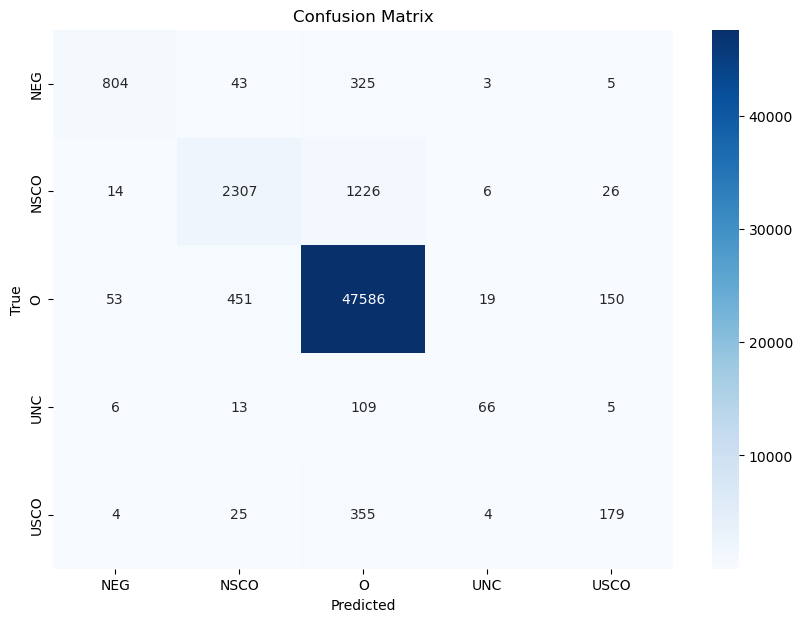

In [138]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Aplanar las listas
y_pred_flat = [label for sublist in y_pred for label in sublist]
y_test_flat = [label for sublist in y_test for label in sublist]

# Calcular las métricas
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_flat, y_pred_flat, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Matriz de confusión
labels = sorted(set(y_test_flat))
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat, labels=labels)

# Graficar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [139]:
labels = list(crf.classes_)
labels.remove('O')
y_pred = crf.predict(x_test_converted)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.6877610499696958

In [ ]:
y_pred = crf.predict(x_train_converted)
print(metrics.flat_accuracy_score(y_train, y_pred))

0.9652632194779488
